### 1. Library Imports

In [1]:
# custom imports
from helpers import *

# standard imports
import os

# torch imports
import torch.nn as nn
import torch

# detectron2 imports
from detectron2.modeling import BACKBONE_REGISTRY, Backbone, ShapeSpec
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator
from segmentation_models_pytorch.encoders import get_encoder

/hpc/group/aipi540-s23/sl808/miniconda3/envs/bme548_fp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Implemented Image Transformation Functions

- Illumination: We will try to simluate the absorbtion of light wave (amplitude + phase shift) by simulating 12 microcope LED's at different angle of illumination. This would be a custom layer with optimizable weights
- Contrast normalization: The myeloma cells have varying levels of contrast as compared to other cells and tissues, so normalizing the contrast can help them be more visible
- Morphological operations: Erosion or dilation operations can smooth the edges of the cells can help us detect the cancer cells better
- Gradient Filters: Sobel filter can help identify the boundaries of the cells better
- Color Channels: Manipulate the different color channels (RGB) of the image by enhancing the effect of either red, green, or blue channel
- Blur Filter: Try the Gaussian blur filters and Median blur filter to smooth the image and reduce the noise

#### a. Selecting the image transformation type to use

In [2]:
## Filter Options:

# 1). IlluminationSimulation
# 2). ContrastNormalization
# 3). Dilation, Erosion
# 4). SobelFilter
# 5). EnhanceRedColor, EnhanceGreenColor, EnhanceBlueColor,
# 6). MedianFilter, GaussianBlur

TRANSFORM_TYPE = None

#### b. Testing the selected image transformation

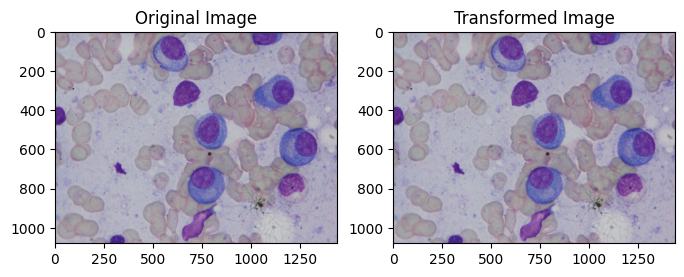

In [3]:
test_transformation("../../BME548L-ML-and-Imaging-Final-Project/TCIA_SegPC_dataset/coco/x/106.bmp", transformation_type=TRANSFORM_TYPE)

### 3. Detectron2 MASK RCNN Configuration Setup

In [5]:
## Initialize model configuration
cfg = get_cfg()

## Set parameters
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"))
cfg.DATASETS.TRAIN = ("SegPC_train",)
cfg.DATASETS.TEST = ("SegPC_val",)

cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02/8
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'

cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.MAX_ITER = 3725
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 250
cfg.MODEL.BACKBONE.NAME = "Effb5"

cfg.CUDNN_BENCHMARK = True
cfg.OUTPUT_DIR = f"../outputs/{TRANSFORM_TYPE}/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

if TRANSFORM_TYPE == "IlluminationSimulation":
    # Additional parameters for "IlluminationSimulation Transform"
    cfg.MODEL.PIXEL_MEAN = [0.5]
    cfg.MODEL.PIXEL_STD = [1.0]

### 4. Initializing the Backbone Layer Architecture for MASK RCNN Model

In [6]:
if TRANSFORM_TYPE == "IlluminationSimulation":
    class NonNegativeConv2d(nn.Conv2d):
        def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
            super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        
        def forward(self, x):
            self.weight.data.clamp_min_(0.0)
            return nn.functional.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

    # Define netowrk architecture
    @BACKBONE_REGISTRY.register()
    class Effb5(Backbone):
        def __init__(self, cfg, input_shape):
            super().__init__()
            
            # Set up the illumination layer
            self.illumination = NonNegativeConv2d(in_channels=12, out_channels=12, kernel_size=1, stride=1, padding=0, bias=False)
            torch.nn.init.normal_(self.illumination.weight, mean=0.0, std=0.05)
            
            in_channels = 1
            encoder_name = 'timm-efficientnet-b5'
            encoder_depth = 5
            encoder_weights = 'noisy-student'
            self.encoder = get_encoder(encoder_name,
                    in_channels=in_channels,
                    depth=encoder_depth,
                    weights=encoder_weights)
            self.channels = self.encoder.out_channels
            self.conv = nn.ModuleList(
                [nn.Conv2d(self.channels[i],256,3,stride = 2, padding = 1) for i in range(len(self.channels))]
            )
            self.names = ["p"+str(i+1) for i in range(6)]
            
        def forward(self, image):

            illuminated_image = torch.sum(self.illumination(image), dim=1, keepdim=True)
            features = self.encoder(illuminated_image)
            out = {self.names[i]: self.conv[i](features[i]) for i in range(1, len(features))}
            return out

        def output_shape(self):
            out_shape = {self.names[i]: ShapeSpec(channels =256, stride = 2**(i+1)) for i in range(1, len(self.names))}
            return out_shape
        
else:
    # Define netowrk architecture
    @BACKBONE_REGISTRY.register()
    class Effb5(Backbone):
        def __init__(self, cfg, input_shape):
            super().__init__()
            
            in_channels = 3
            encoder_name = 'timm-efficientnet-b5'
            encoder_depth = 5
            encoder_weights = 'noisy-student'
            self.encoder = get_encoder(encoder_name,
                    in_channels=in_channels,
                    depth=encoder_depth,
                    weights=encoder_weights)
            self.channels = self.encoder.out_channels
            self.conv = nn.ModuleList(
                [nn.Conv2d(self.channels[i],256,3,stride = 2, padding = 1) for i in range(len(self.channels))]
            )
            self.names = ["p"+str(i+1) for i in range(6)]
            
        def forward(self, image):

            features = self.encoder(image)
            out = {self.names[i]: self.conv[i](features[i]) for i in range(1, len(features))}
            return out

        def output_shape(self):
            out_shape = {self.names[i]: ShapeSpec(channels =256, stride = 2**(i+1)) for i in range(1, len(self.names))}
            return out_shape

### 5. Overloading the "build_train_loader" & "build_test_loader" methods of "DefaultTrainer" Class to add image transformations

In [7]:
class CocoTrainer(DefaultTrainer):
    """
    Custom class for model training
    """
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
            
        return COCOEvaluator(dataset_name, cfg, False, output_folder)
    
    @classmethod
    def build_train_loader(cls, cfg):
        
        mapper = DatasetMapper(cfg, is_train=True, augmentations=select_transformation(TRANSFORM_TYPE))
        
        return build_detection_train_loader(cfg, mapper=mapper)
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        
        mapper = DatasetMapper(cfg, is_train=False, augmentations=select_transformation(TRANSFORM_TYPE))
        
        return build_detection_test_loader(cfg, dataset_name, mapper=mapper)

### 6. Initializing the datasets

In [8]:
register_coco_instances("SegPC_train", {}, "../../BME548L-ML-and-Imaging-Final-Project/TCIA_SegPC_dataset/coco_two_train/COCO.json", "../../BME548L-ML-and-Imaging-Final-Project/TCIA_SegPC_dataset/coco_two_train/x")
register_coco_instances("SegPC_val", {}, "../../BME548L-ML-and-Imaging-Final-Project/TCIA_SegPC_dataset/coco_two_val/COCO.json", "../../BME548L-ML-and-Imaging-Final-Project/TCIA_SegPC_dataset/coco_two_val/x")

train_meta = MetadataCatalog.get('SegPC_train')
val_meta = MetadataCatalog.get('SegPC_val')

train_dicts = DatasetCatalog.get("SegPC_train")
val_dicts = DatasetCatalog.get("SegPC_val")

### 7. Training the Model

In [ ]:
## Train the model
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/30 01:29:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): Effb5(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
       

Skip loading parameter 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.2.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) 

[04/30 01:30:00 d2.engine.train_loop]: Starting training from iteration 0


/hpc/group/aipi540-s23/sl808/miniconda3/envs/bme548_fp/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/30 01:30:13 d2.utils.events]:  eta: 0:35:12  iter: 19  total_loss: 5.25  loss_cls_stage0: 0.9449  loss_box_reg_stage0: 0.8793  loss_cls_stage1: 0.8859  loss_box_reg_stage1: 0.4746  loss_cls_stage2: 0.8724  loss_box_reg_stage2: 0.1822  loss_mask: 0.6913  loss_rpn_cls: 0.3167  loss_rpn_loc: 0.2579  time: 0.5693  data_time: 0.0427  lr: 0.00047618  max_mem: 26039M
[04/30 01:30:24 d2.utils.events]:  eta: 0:35:10  iter: 39  total_loss: 4.173  loss_cls_stage0: 0.7023  loss_box_reg_stage0: 0.8692  loss_cls_stage1: 0.4626  loss_box_reg_stage1: 0.6122  loss_cls_stage2: 0.2612  loss_box_reg_stage2: 0.2754  loss_mask: 0.6669  loss_rpn_cls: 0.0889  loss_rpn_loc: 0.1051  time: 0.5750  data_time: 0.0207  lr: 0.00097479  max_mem: 26039M
[04/30 01:30:36 d2.utils.events]:  eta: 0:35:08  iter: 59  total_loss: 4.272  loss_cls_stage0: 0.6034  loss_box_reg_stage0: 0.8179  loss_cls_stage1: 0.534  loss_box_reg_stage1: 0.9028  loss_cls_stage2: 0.3129  loss_box_reg_stage2: 0.393  loss_mask: 0.5926  loss_rpn